In [1]:
#compare to a base model
#scale_pos_weight = round(NoClaim/HasClaim)
import pandas as pd
import numpy as np
from math import isnan

In [2]:
#data
dataset = pd.read_csv('/home/kate/data/ClaimPrediction/fdata_v1_encd.csv', index_col=None)
target_column = 'hasclaim'

In [3]:
target_column = 'hasclaim'
BestModel=[ 'accidentpreventioncourseind_encd',
 'carpoolind_encd',
 'classcd_encd',
 'driverage',
 'drivernumber',
 'driverstatuscd_encd',
 'drivertrainingind_encd',
 'estimatedannualdistance',
 'gooddriverind_encd',
 'maturedriverind_encd',
 'mvrstatus_encd',
 'mvrstatusage',
 'ratingvalue',
 'relationshiptoinsuredcd_encd',
 'scholasticdiscountind_encd',
 'vehbodytypecd_encd',
 'vehicleage',
 'vehnumber',
 'gendercd_encd',
 'maritalstatuscd_encd',
 'enginecylinders_encd',
 'passiveseatbeltind_encd',
 'acci_pointschargedterm',
 'acci_last_infractionage']
ShortBestModel2 = [ 'accidentpreventioncourseind_encd',
 'carpoolind_encd',
 'classcd_encd',
 'driverage',
 'drivernumber',
 'driverstatuscd_encd',
 'drivertrainingind_encd',
 'estimatedannualdistance',
 'gooddriverind_encd',
 'maturedriverind_encd',
 'mvrstatus_encd',
 'mvrstatusage',
 'ratingvalue',
 'relationshiptoinsuredcd_encd',
 'scholasticdiscountind_encd',
 'vehbodytypecd_encd',
 'vehicleage',
 'vehnumber',
 'gendercd_encd',
 'maritalstatuscd_encd',
 'enginecylinders_encd',
 'passiveseatbeltind_encd']
featureset=BestModel

In [4]:
#models and analyzing results directory
ModelsDir='/home/kate/data/ClaimPrediction/p5_ScalePosWeight/'

In [5]:
#comparing model metrics with t-test
#and save results
import scipy.stats as stats
def AnalyzeAndSaveModelsResults(result_df,result_lst,ModelName,filename):
    df=pd.DataFrame([result_lst])
    TestSizeColumns=['S0.45','S0.4','S0.35','S0.3','S0.25','S0.2','S0.15','S0.1']
    #TestSizeColumns=['S0.2','S0.15','S0.1']
    df.columns=['Model']+TestSizeColumns
    #mean
    df['Mean'] = df.drop('Model', axis=1).mean(axis=1)
    df['t-pvalue'] = 1
    df['t-statistic'] = 0
    df['Group'] = 1
    #t-test with base model
    if ModelName!='BaseModel':
        base_model=result_df[result_df['Model'] == 'BaseModel'].iloc[0]
        current_model=df.iloc[0]
        t=stats.ttest_ind(base_model[TestSizeColumns].tolist(),current_model[TestSizeColumns].tolist())
        line_to_save=[current_model['Model']]
        line_to_save.extend(current_model[TestSizeColumns].tolist())
        line_to_save.append(current_model[TestSizeColumns].mean())
        line_to_save.append(t.pvalue)
        line_to_save.append(t.statistic)
        if ((t.pvalue<=0.05) and (base_model['Mean']<current_model['Mean'])):
            line_to_save.append(2)
        elif ((t.pvalue<=0.05) and (base_model['Mean']>current_model['Mean'])):
            line_to_save.append(3)    
        else:
            line_to_save.append(1)                  
        df_to_save=pd.DataFrame([line_to_save])
        df_to_save.columns=['Model']+TestSizeColumns+['Mean','t-pvalue','t-statistic','Group']
        result_df=result_df.append(df_to_save, ignore_index=True)
    else:
        result_df=result_df.append(df, ignore_index=True)
    result_df.to_csv(ModelsDir+filename, index = False)
    return result_df

In [6]:
#xgb library and some base parameters
import xgboost as xgb
base_params = {'objective': 'binary:logistic', 'eval_metric': 'auc', 'silent': True,'booster': 'gbtree','seed':42}

In [7]:
#Evaluation metric to be used in tuning
from sklearn.metrics import roc_auc_score
def gini(y, pred):
    g = np.asarray(np.c_[y, pred, np.arange(len(y)) ], dtype=np.float)
    g = g[np.lexsort((g[:,2], -1*g[:,1]))]
    gs = g[:,0].cumsum().sum() / g[:,0].sum()
    gs -= (len(y) + 1) / 2.
    return gs / len(y)
def gini_xgb(pred, y):
    y = y.get_label()
    return 'gini', gini(y, pred) / gini(y, y)

In [8]:
#StratifiedKFold
from sklearn.model_selection import StratifiedKFold
nrounds=5000 # need to change to 2000
kfold = 10  # need to change to 10
skf = StratifiedKFold(n_splits=kfold, random_state=42)

In [9]:
#splitting to train/test in the loop below
from sklearn.model_selection import train_test_split

In [10]:
#each line in the file contains the model name and set of parameters to analize
models = pd.read_csv(ModelsDir+'Models.csv', index_col=None)

In [11]:
#summary for test and train metrics for each model to test overfitting
models_test_gini_df=pd.DataFrame()
models_test_roc_auc_df=pd.DataFrame()
#
models_train_gini_df=pd.DataFrame()
models_train_roc_auc_df=pd.DataFrame()
#
base_model_df=pd.DataFrame()

In [12]:
for index, row in models.iterrows():
    #for test and train metrics for each model to test overfitting
    gini_test_lst=[]
    roc_auc_test_lst=[]
    gini_train_lst=[]
    roc_auc_train_lst=[]
    #Starting analyzing metric
    print (index, ': Analyzing model %s'%row['Model'])
    #reading model parameters from a row to a dictionary
    parameterset=row[1:10].to_dict()
    parameterset={k: parameterset[k] for k in parameterset if not isnan(parameterset[k])}
    #join with base parameters
    xgb_params = {**base_params, **parameterset}
    #int is needed for several parameters
    try:
        xgb_params['min_child_weight'] = int(xgb_params['min_child_weight'])
    except KeyError:
    # Key is not present
        pass
    try:
        xgb_params['max_depth'] = int(xgb_params['max_depth'])
    except KeyError:
    # Key is not present
        pass    
    try:
        xgb_params['max_delta_step'] = int(xgb_params['max_delta_step'])
    except KeyError:
    # Key is not present
        pass           
    gini_test_lst.append(row['Model'])
    roc_auc_test_lst.append(row['Model'])
    gini_train_lst.append(row['Model'])
    roc_auc_train_lst.append(row['Model'])
    #calculating metrics for the current parameter set and 
    #several data sizes
    for s in (0.45,0.4,0.35,0.3,0.25,0.2,0.15,0.1):
    #for s in (0.2,0.15,0.1):
        print ('Test size %s'%s)
        X, X_test, y, y_test = train_test_split(dataset.loc[:,featureset], dataset[target_column], test_size=s, random_state=42)
                
        #prediction dataframes
        y_pred_test=pd.DataFrame(index=y_test.index)
        y_pred_test[target_column]=0
        y_pred_train=pd.DataFrame(index=y.index)
        y_pred_train[target_column]=0
        #
        X = X.values
        y = y.values
        #Stratified Fold
        for i, (train_index, test_index) in enumerate(skf.split(X, y)):
            print(' xgb kfold: {}  of  {} : '.format(i+1, kfold))
            #getting fold data
            X_train, X_valid = X[train_index], X[test_index]
            y_train, y_valid = y[train_index], y[test_index]
            #calculating ratio sum(negative cases) / sum(positive cases) to get scale_pos_weight
            HasClaim=len(y_train[y_train==1])
            NoClaim=len(y_train[y_train==0])
            scale_pos_weight=round(NoClaim/HasClaim)
            tmp={'scale_pos_weight':scale_pos_weight}
            xgb_params = {**xgb_params, **tmp}
            print(xgb_params)
            #applying XGB
            d_train = xgb.DMatrix(X_train, y_train) 
            d_valid = xgb.DMatrix(X_valid, y_valid) 
            watchlist = [(d_train, 'train'), (d_valid, 'valid')]
            xgb_model = xgb.train(xgb_params, d_train, nrounds, watchlist, early_stopping_rounds=100, 
                          feval=gini_xgb, maximize=True, verbose_eval=1000)
            y_pred_test[target_column] +=  xgb_model.predict(xgb.DMatrix(X_test.values), ntree_limit=xgb_model.best_ntree_limit+50) / (kfold)
            y_pred_train[target_column] += xgb_model.predict(xgb.DMatrix(X), ntree_limit=xgb_model.best_ntree_limit+50) / (kfold)
        #Prediction results
        #test
        g=gini(y_test,y_pred_test)/gini(y_test,y_test)
        print('Test Gini - %f'%g)
        gini_test_lst.append(g)
        ROC_AUC=roc_auc_score(y_test, y_pred_test)
        print('Test ROC_AUC - %f'%ROC_AUC)
        roc_auc_test_lst.append(ROC_AUC)
        #train
        g=gini(y,y_pred_train)/gini(y,y)
        print('Train Gini - %f'%g)
        gini_train_lst.append(g)
        ROC_AUC=roc_auc_score(y, y_pred_train)
        print('Train ROC_AUC - %f'%ROC_AUC)
        roc_auc_train_lst.append(ROC_AUC)
    #save model analysis results
    models_test_gini_df=AnalyzeAndSaveModelsResults(models_test_gini_df,gini_test_lst,row['Model'],'models_test_gini.csv')
    models_test_roc_auc_df=AnalyzeAndSaveModelsResults(models_test_roc_auc_df,roc_auc_test_lst,row['Model'],'models_test_roc_auc.csv')
    models_train_gini_df=AnalyzeAndSaveModelsResults(models_train_gini_df,gini_train_lst,row['Model'],'models_train_gini.csv')
    models_train_roc_auc_df=AnalyzeAndSaveModelsResults(models_train_roc_auc_df,roc_auc_train_lst,row['Model'],'models_train_roc_auc.csv')

0 : Analyzing model BaseModel
Test size 0.45
 xgb kfold: 1  of  10 : 
{'objective': 'binary:logistic', 'eval_metric': 'auc', 'silent': True, 'booster': 'gbtree', 'seed': 42, 'colsample_bytree': 0.9, 'eta': 0.02, 'max_depth': 4, 'scale_pos_weight': 18}
[0]	train-auc:0.638261	valid-auc:0.636225	train-gini:0.27629	valid-gini:0.271015
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[368]	train-auc:0.75086	valid-auc:0.713452	train-gini:0.501721	valid-gini:0.426897

 xgb kfold: 2  of  10 : 
{'objective': 'binary:logistic', 'eval_metric': 'auc', 'silent': True, 'booster': 'gbtree', 'seed': 42, 'colsample_bytree': 0.9, 'eta': 0.02, 'max_depth': 4, 'scale_pos_weight': 18}
[0]	train-auc:0.636734	valid-auc:0.627728	train-gini:0.273501	valid-gini:0.244178
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't 

Stopping. Best iteration:
[475]	train-auc:0.752527	valid-auc:0.724678	train-gini:0.505054	valid-gini:0.449356

 xgb kfold: 6  of  10 : 
{'objective': 'binary:logistic', 'eval_metric': 'auc', 'silent': True, 'booster': 'gbtree', 'seed': 42, 'colsample_bytree': 0.9, 'eta': 0.02, 'max_depth': 4, 'scale_pos_weight': 18}
[0]	train-auc:0.638369	valid-auc:0.63536	train-gini:0.275639	valid-gini:0.268945
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[852]	train-auc:0.768207	valid-auc:0.700559	train-gini:0.536415	valid-gini:0.401119

 xgb kfold: 7  of  10 : 
{'objective': 'binary:logistic', 'eval_metric': 'auc', 'silent': True, 'booster': 'gbtree', 'seed': 42, 'colsample_bytree': 0.9, 'eta': 0.02, 'max_depth': 4, 'scale_pos_weight': 18}
[0]	train-auc:0.640026	valid-auc:0.618646	train-gini:0.279	valid-gini:0.239643
Multiple eval metrics have been passed: 'valid-gini' will 

Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[816]	train-auc:0.76559	valid-auc:0.704629	train-gini:0.531181	valid-gini:0.409256

Test Gini - 0.420768
Test ROC_AUC - 0.710384
Train Gini - 0.515867
Train ROC_AUC - 0.757934
Test size 0.3
 xgb kfold: 1  of  10 : 
{'objective': 'binary:logistic', 'eval_metric': 'auc', 'silent': True, 'booster': 'gbtree', 'seed': 42, 'colsample_bytree': 0.9, 'eta': 0.02, 'max_depth': 4, 'scale_pos_weight': 18}
[0]	train-auc:0.636389	valid-auc:0.616591	train-gini:0.272522	valid-gini:0.240795
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[412]	train-auc:0.746017	valid-auc:0.716039	train-gini:0.492033	valid-gini:0.432078

 xgb kfold: 2  of  10 : 
{'objective': 'binary:logistic', 'eval_metric': 'auc', 'silent': Tr

Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[566]	train-auc:0.752667	valid-auc:0.716118	train-gini:0.505334	valid-gini:0.43224

 xgb kfold: 6  of  10 : 
{'objective': 'binary:logistic', 'eval_metric': 'auc', 'silent': True, 'booster': 'gbtree', 'seed': 42, 'colsample_bytree': 0.9, 'eta': 0.02, 'max_depth': 4, 'scale_pos_weight': 18}
[0]	train-auc:0.630502	valid-auc:0.628838	train-gini:0.262064	valid-gini:0.262008
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[523]	train-auc:0.750731	valid-auc:0.724601	train-gini:0.501463	valid-gini:0.449201

 xgb kfold: 7  of  10 : 
{'objective': 'binary:logistic', 'eval_metric': 'auc', 'silent': True, 'booster': 'gbtree', 'seed': 42, 'colsample_bytree': 0.9, 'eta': 0.02, 'max_depth': 4, 'scale_pos_weig

Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[597]	train-auc:0.752137	valid-auc:0.70722	train-gini:0.504274	valid-gini:0.41444

Test Gini - 0.419116
Test ROC_AUC - 0.709558
Train Gini - 0.505169
Train ROC_AUC - 0.752584
Test size 0.15
 xgb kfold: 1  of  10 : 
{'objective': 'binary:logistic', 'eval_metric': 'auc', 'silent': True, 'booster': 'gbtree', 'seed': 42, 'colsample_bytree': 0.9, 'eta': 0.02, 'max_depth': 4, 'scale_pos_weight': 18}
[0]	train-auc:0.634368	valid-auc:0.641093	train-gini:0.269135	valid-gini:0.268847
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[736]	train-auc:0.755794	valid-auc:0.715361	train-gini:0.511588	valid-gini:0.430721

 xgb kfold: 2  of  10 : 
{'objective': 'binary:logistic', 'eval_metric': 'auc', 'silent': Tr

Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
[1000]	train-auc:0.761278	valid-auc:0.7139	train-gini:0.522556	valid-gini:0.4278
Stopping. Best iteration:
[996]	train-auc:0.761157	valid-auc:0.713977	train-gini:0.522315	valid-gini:0.427954

 xgb kfold: 6  of  10 : 
{'objective': 'binary:logistic', 'eval_metric': 'auc', 'silent': True, 'booster': 'gbtree', 'seed': 42, 'colsample_bytree': 0.9, 'eta': 0.02, 'max_depth': 4, 'scale_pos_weight': 18}
[0]	train-auc:0.634935	valid-auc:0.636259	train-gini:0.269216	valid-gini:0.260991
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[592]	train-auc:0.749031	valid-auc:0.717487	train-gini:0.498062	valid-gini:0.434973

 xgb kfold: 7  of  10 : 
{'objective': 'binary:logistic', 'eval_metric': 'auc', 'silent': True, 'booster': 'gbtree',

[0]	train-auc:0.683755	valid-auc:0.649724	train-gini:0.367067	valid-gini:0.292296
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[37]	train-auc:0.828385	valid-auc:0.696233	train-gini:0.656769	valid-gini:0.392468

 xgb kfold: 2  of  10 : 
{'objective': 'binary:logistic', 'eval_metric': 'auc', 'silent': True, 'booster': 'gbtree', 'seed': 42, 'scale_pos_weight': 18}
[0]	train-auc:0.681159	valid-auc:0.660604	train-gini:0.361804	valid-gini:0.315526
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[17]	train-auc:0.789199	valid-auc:0.703929	train-gini:0.578397	valid-gini:0.407856

 xgb kfold: 3  of  10 : 
{'objective': 'binary:logistic', 'eval_metric': 'auc', 'silent': True, 'booster': 'gbtree', 'seed': 42, 'scale_pos_weight': 18}
[0]	train-auc:0.68

 xgb kfold: 8  of  10 : 
{'objective': 'binary:logistic', 'eval_metric': 'auc', 'silent': True, 'booster': 'gbtree', 'seed': 42, 'scale_pos_weight': 18}
[0]	train-auc:0.680726	valid-auc:0.656259	train-gini:0.360936	valid-gini:0.314444
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[20]	train-auc:0.791535	valid-auc:0.694812	train-gini:0.583069	valid-gini:0.389621

 xgb kfold: 9  of  10 : 
{'objective': 'binary:logistic', 'eval_metric': 'auc', 'silent': True, 'booster': 'gbtree', 'seed': 42, 'scale_pos_weight': 18}
[0]	train-auc:0.680315	valid-auc:0.627154	train-gini:0.360421	valid-gini:0.25928
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[20]	train-auc:0.784885	valid-auc:0.683978	train-gini:0.569772	valid-gini:0.367957

 xgb kfold: 10  of 

Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[12]	train-auc:0.765106	valid-auc:0.711815	train-gini:0.530212	valid-gini:0.42363

 xgb kfold: 5  of  10 : 
{'objective': 'binary:logistic', 'eval_metric': 'auc', 'silent': True, 'booster': 'gbtree', 'seed': 42, 'scale_pos_weight': 18}
[0]	train-auc:0.677001	valid-auc:0.658231	train-gini:0.354511	valid-gini:0.315109
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[17]	train-auc:0.7801	valid-auc:0.710707	train-gini:0.560201	valid-gini:0.421414

 xgb kfold: 6  of  10 : 
{'objective': 'binary:logistic', 'eval_metric': 'auc', 'silent': True, 'booster': 'gbtree', 'seed': 42, 'scale_pos_weight': 18}
[0]	train-auc:0.680563	valid-auc:0.659743	train-gini:0.36155	valid-gini:0.320755
Multiple eval metrics 

Test Gini - 0.396288
Test ROC_AUC - 0.698144
Train Gini - 0.703724
Train ROC_AUC - 0.851862
Test size 0.15
 xgb kfold: 1  of  10 : 
{'objective': 'binary:logistic', 'eval_metric': 'auc', 'silent': True, 'booster': 'gbtree', 'seed': 42, 'scale_pos_weight': 18}
[0]	train-auc:0.676037	valid-auc:0.644057	train-gini:0.352161	valid-gini:0.281127
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[24]	train-auc:0.782309	valid-auc:0.703034	train-gini:0.564619	valid-gini:0.406065

 xgb kfold: 2  of  10 : 
{'objective': 'binary:logistic', 'eval_metric': 'auc', 'silent': True, 'booster': 'gbtree', 'seed': 42, 'scale_pos_weight': 18}
[0]	train-auc:0.681782	valid-auc:0.65602	train-gini:0.363647	valid-gini:0.312373
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iterati

Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[10]	train-auc:0.749908	valid-auc:0.706266	train-gini:0.499835	valid-gini:0.412529

 xgb kfold: 8  of  10 : 
{'objective': 'binary:logistic', 'eval_metric': 'auc', 'silent': True, 'booster': 'gbtree', 'seed': 42, 'scale_pos_weight': 18}
[0]	train-auc:0.677997	valid-auc:0.654121	train-gini:0.356055	valid-gini:0.309083
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[30]	train-auc:0.787736	valid-auc:0.707585	train-gini:0.575473	valid-gini:0.415168

 xgb kfold: 9  of  10 : 
{'objective': 'binary:logistic', 'eval_metric': 'auc', 'silent': True, 'booster': 'gbtree', 'seed': 42, 'scale_pos_weight': 18}
[0]	train-auc:0.677322	valid-auc:0.637045	train-gini:0.354082	valid-gini:0.277281
Multiple eval metr

Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[159]	train-auc:0.747724	valid-auc:0.708611	train-gini:0.495449	valid-gini:0.417214

 xgb kfold: 3  of  10 : 
{'objective': 'binary:logistic', 'eval_metric': 'auc', 'silent': True, 'booster': 'gbtree', 'seed': 42, 'colsample_bytree': 0.5, 'eta': 0.02, 'max_depth': 5, 'scale_pos_weight': 18}
[0]	train-auc:0.629214	valid-auc:0.648963	train-gini:0.258118	valid-gini:0.278803
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[404]	train-auc:0.771827	valid-auc:0.721173	train-gini:0.543654	valid-gini:0.442347

 xgb kfold: 4  of  10 : 
{'objective': 'binary:logistic', 'eval_metric': 'auc', 'silent': True, 'booster': 'gbtree', 'seed': 42, 'colsample_bytree': 0.5, 'eta': 0.02, 'max_depth': 5, 'scale_pos_wei

Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[584]	train-auc:0.781701	valid-auc:0.715139	train-gini:0.563402	valid-gini:0.430278

 xgb kfold: 8  of  10 : 
{'objective': 'binary:logistic', 'eval_metric': 'auc', 'silent': True, 'booster': 'gbtree', 'seed': 42, 'colsample_bytree': 0.5, 'eta': 0.02, 'max_depth': 5, 'scale_pos_weight': 18}
[0]	train-auc:0.630601	valid-auc:0.631273	train-gini:0.260331	valid-gini:0.266964
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[210]	train-auc:0.753371	valid-auc:0.697103	train-gini:0.506743	valid-gini:0.394206

 xgb kfold: 9  of  10 : 
{'objective': 'binary:logistic', 'eval_metric': 'auc', 'silent': True, 'booster': 'gbtree', 'seed': 42, 'colsample_bytree': 0.5, 'eta': 0.02, 'max_depth': 5, 'scale_pos_wei

Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[469]	train-auc:0.769335	valid-auc:0.719428	train-gini:0.538671	valid-gini:0.438857

 xgb kfold: 3  of  10 : 
{'objective': 'binary:logistic', 'eval_metric': 'auc', 'silent': True, 'booster': 'gbtree', 'seed': 42, 'colsample_bytree': 0.5, 'eta': 0.02, 'max_depth': 5, 'scale_pos_weight': 18}
[0]	train-auc:0.633185	valid-auc:0.625372	train-gini:0.267446	valid-gini:0.255648
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[330]	train-auc:0.761827	valid-auc:0.699977	train-gini:0.523654	valid-gini:0.399954

 xgb kfold: 4  of  10 : 
{'objective': 'binary:logistic', 'eval_metric': 'auc', 'silent': True, 'booster': 'gbtree', 'seed': 42, 'colsample_bytree': 0.5, 'eta': 0.02, 'max_depth': 5, 'scale_pos_wei

Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[410]	train-auc:0.763772	valid-auc:0.714231	train-gini:0.527544	valid-gini:0.428461

 xgb kfold: 8  of  10 : 
{'objective': 'binary:logistic', 'eval_metric': 'auc', 'silent': True, 'booster': 'gbtree', 'seed': 42, 'colsample_bytree': 0.5, 'eta': 0.02, 'max_depth': 5, 'scale_pos_weight': 18}
[0]	train-auc:0.633113	valid-auc:0.627729	train-gini:0.266862	valid-gini:0.263795
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[602]	train-auc:0.774395	valid-auc:0.715004	train-gini:0.548789	valid-gini:0.430009

 xgb kfold: 9  of  10 : 
{'objective': 'binary:logistic', 'eval_metric': 'auc', 'silent': True, 'booster': 'gbtree', 'seed': 42, 'colsample_bytree': 0.5, 'eta': 0.02, 'max_depth': 5, 'scale_pos_wei

Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[544]	train-auc:0.76899	valid-auc:0.715204	train-gini:0.537979	valid-gini:0.430407

 xgb kfold: 3  of  10 : 
{'objective': 'binary:logistic', 'eval_metric': 'auc', 'silent': True, 'booster': 'gbtree', 'seed': 42, 'colsample_bytree': 0.5, 'eta': 0.02, 'max_depth': 5, 'scale_pos_weight': 18}
[0]	train-auc:0.629983	valid-auc:0.617816	train-gini:0.258628	valid-gini:0.244654
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[528]	train-auc:0.767064	valid-auc:0.713666	train-gini:0.534128	valid-gini:0.427333

 xgb kfold: 4  of  10 : 
{'objective': 'binary:logistic', 'eval_metric': 'auc', 'silent': True, 'booster': 'gbtree', 'seed': 42, 'colsample_bytree': 0.5, 'eta': 0.02, 'max_depth': 5, 'scale_pos_weig

Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
[1000]	train-auc:0.755424	valid-auc:0.701667	train-gini:0.510848	valid-gini:0.403337
Stopping. Best iteration:
[1625]	train-auc:0.769276	valid-auc:0.705251	train-gini:0.538551	valid-gini:0.410504

 xgb kfold: 7  of  10 : 
{'objective': 'binary:logistic', 'eval_metric': 'auc', 'silent': True, 'booster': 'gbtree', 'seed': 42, 'colsample_bylevel': 0.232094506, 'colsample_bytree': 0.978684648, 'eta': 0.01208041, 'max_depth': 4, 'scale_pos_weight': 18}
[0]	train-auc:0.620021	valid-auc:0.623056	train-gini:0.24045	valid-gini:0.257464
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[765]	train-auc:0.747921	valid-auc:0.716384	train-gini:0.495843	valid-gini:0.432768

 xgb kfold: 8  of  10 : 
{'objective': 'binary:logistic', 'eval_

 xgb kfold: 9  of  10 : 
{'objective': 'binary:logistic', 'eval_metric': 'auc', 'silent': True, 'booster': 'gbtree', 'seed': 42, 'colsample_bylevel': 0.232094506, 'colsample_bytree': 0.978684648, 'eta': 0.01208041, 'max_depth': 4, 'scale_pos_weight': 18}
[0]	train-auc:0.619797	valid-auc:0.618481	train-gini:0.239008	valid-gini:0.255744
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
[1000]	train-auc:0.749155	valid-auc:0.713318	train-gini:0.498309	valid-gini:0.426637
Stopping. Best iteration:
[1602]	train-auc:0.762301	valid-auc:0.716094	train-gini:0.524602	valid-gini:0.432189

 xgb kfold: 10  of  10 : 
{'objective': 'binary:logistic', 'eval_metric': 'auc', 'silent': True, 'booster': 'gbtree', 'seed': 42, 'colsample_bylevel': 0.232094506, 'colsample_bytree': 0.978684648, 'eta': 0.01208041, 'max_depth': 4, 'scale_pos_weight': 18}
[0]	train-auc:0.620798	valid-auc:0.610596	train-gini:0.240712	va

Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
[1000]	train-auc:0.746483	valid-auc:0.71696	train-gini:0.492967	valid-gini:0.433919
Stopping. Best iteration:
[923]	train-auc:0.744452	valid-auc:0.717067	train-gini:0.488904	valid-gini:0.434134

 xgb kfold: 2  of  10 : 
{'objective': 'binary:logistic', 'eval_metric': 'auc', 'silent': True, 'booster': 'gbtree', 'seed': 42, 'colsample_bylevel': 0.232094506, 'colsample_bytree': 0.978684648, 'eta': 0.01208041, 'max_depth': 4, 'scale_pos_weight': 18}
[0]	train-auc:0.619219	valid-auc:0.608965	train-gini:0.238024	valid-gini:0.212439
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
[1000]	train-auc:0.748514	valid-auc:0.698418	train-gini:0.497027	valid-gini:0.396838
Stopping. Best iteration:
[1674]	train-auc:0.761257	valid-auc:0.701366	train-gini:0.522514	

[1000]	train-auc:0.747328	valid-auc:0.69792	train-gini:0.494656	valid-gini:0.395841
Stopping. Best iteration:
[1692]	train-auc:0.760628	valid-auc:0.700402	train-gini:0.521256	valid-gini:0.400804

 xgb kfold: 4  of  10 : 
{'objective': 'binary:logistic', 'eval_metric': 'auc', 'silent': True, 'booster': 'gbtree', 'seed': 42, 'colsample_bylevel': 0.232094506, 'colsample_bytree': 0.978684648, 'eta': 0.01208041, 'max_depth': 4, 'scale_pos_weight': 18}
[0]	train-auc:0.618692	valid-auc:0.611045	train-gini:0.238532	valid-gini:0.223118
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
Stopping. Best iteration:
[893]	train-auc:0.744003	valid-auc:0.714572	train-gini:0.488006	valid-gini:0.429144

 xgb kfold: 5  of  10 : 
{'objective': 'binary:logistic', 'eval_metric': 'auc', 'silent': True, 'booster': 'gbtree', 'seed': 42, 'colsample_bylevel': 0.232094506, 'colsample_bytree': 0.978684648, 'eta': 0.01208

 xgb kfold: 6  of  10 : 
{'objective': 'binary:logistic', 'eval_metric': 'auc', 'silent': True, 'booster': 'gbtree', 'seed': 42, 'colsample_bylevel': 0.232094506, 'colsample_bytree': 0.978684648, 'eta': 0.01208041, 'max_depth': 4, 'scale_pos_weight': 18}
[0]	train-auc:0.61965	valid-auc:0.606006	train-gini:0.240434	valid-gini:0.210883
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
[1000]	train-auc:0.744725	valid-auc:0.716422	train-gini:0.48945	valid-gini:0.432845
Stopping. Best iteration:
[1276]	train-auc:0.749942	valid-auc:0.717361	train-gini:0.499884	valid-gini:0.434723

 xgb kfold: 7  of  10 : 
{'objective': 'binary:logistic', 'eval_metric': 'auc', 'silent': True, 'booster': 'gbtree', 'seed': 42, 'colsample_bylevel': 0.232094506, 'colsample_bytree': 0.978684648, 'eta': 0.01208041, 'max_depth': 4, 'scale_pos_weight': 18}
[0]	train-auc:0.619616	valid-auc:0.621051	train-gini:0.240009	valid

Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
[1000]	train-auc:0.744716	valid-auc:0.714713	train-gini:0.489431	valid-gini:0.429426
[2000]	train-auc:0.759907	valid-auc:0.71824	train-gini:0.519814	valid-gini:0.43648
Stopping. Best iteration:
[1962]	train-auc:0.759331	valid-auc:0.718288	train-gini:0.518662	valid-gini:0.436575

 xgb kfold: 9  of  10 : 
{'objective': 'binary:logistic', 'eval_metric': 'auc', 'silent': True, 'booster': 'gbtree', 'seed': 42, 'colsample_bylevel': 0.232094506, 'colsample_bytree': 0.978684648, 'eta': 0.01208041, 'max_depth': 4, 'scale_pos_weight': 18}
[0]	train-auc:0.619894	valid-auc:0.620178	train-gini:0.239393	valid-gini:0.248846
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
[1000]	train-auc:0.745904	valid-auc:0.699415	train-gini:0.491808	valid-gini:0.398829
Stoppi

Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
[1000]	train-auc:0.743441	valid-auc:0.70595	train-gini:0.486882	valid-gini:0.411899
[2000]	train-auc:0.75795	valid-auc:0.708192	train-gini:0.515899	valid-gini:0.416384
Stopping. Best iteration:
[1980]	train-auc:0.757718	valid-auc:0.708357	train-gini:0.515437	valid-gini:0.416714

Test Gini - 0.418192
Test ROC_AUC - 0.709096
Train Gini - 0.501722
Train ROC_AUC - 0.750861


In [13]:
print(xgb_params)

{'objective': 'binary:logistic', 'eval_metric': 'auc', 'silent': True, 'booster': 'gbtree', 'seed': 42, 'colsample_bylevel': 0.232094506, 'colsample_bytree': 0.978684648, 'eta': 0.01208041, 'max_depth': 4, 'scale_pos_weight': 18}


Red and Green bars below indicates models where mean of gini is likely different from a previous model

In [14]:
models_test_gini_df

,Model,S0.45,S0.4,S0.35,S0.3,S0.25,S0.2,S0.15,S0.1,Mean,t-pvalue,t-statistic,Group
0,BaseModel,0.414162,0.419354,0.420768,0.422208,0.420643,0.419116,0.418641,0.415378,0.418784,1.000000e+00,0.000000,1
1,Default,0.387496,0.388412,0.395269,0.393876,0.391836,0.396288,0.385929,0.404000,0.392888,1.961837e-08,11.323873,3
2,NewWorking,0.414246,0.418872,0.422425,0.425257,0.421187,0.419533,0.420132,0.417696,0.419919,4.642721e-01,-0.752403,1
3,AdjustedOptimized,0.414219,0.419391,0.421406,0.422331,0.420470,0.419647,0.419385,0.418192,0.419380,6.536531e-01,-0.458467,1


In [15]:
models_test_gini_df.set_index('Model', inplace=True)

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
colors = {1: 'blue', 2: 'green',3: 'red'}

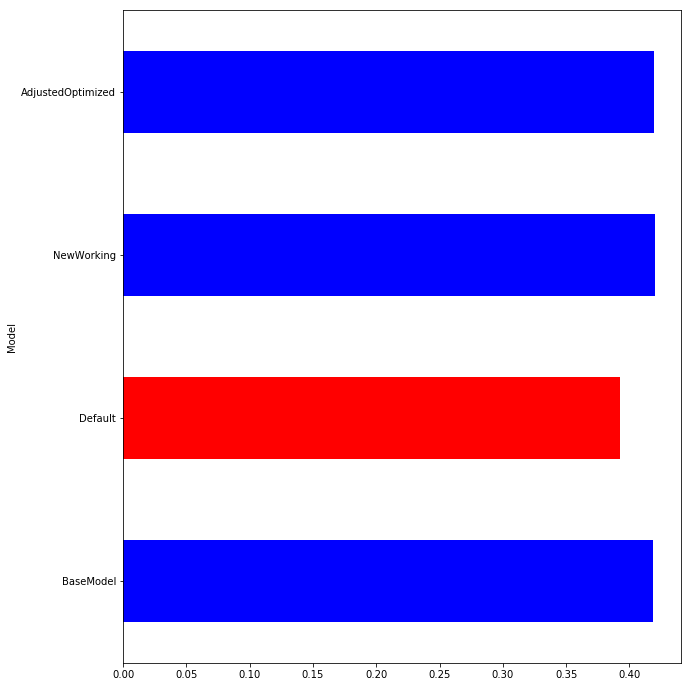

In [18]:
customcmap = tuple(models_test_gini_df['Group'].map(colors))
models_test_gini_df['Mean'].plot(kind='barh',  color=[customcmap], figsize=(10, 12))